<a href="https://colab.research.google.com/github/SummerProjectTEAM-10/Diabets-Prediction/blob/SRUTHI/RandomizesSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv('/content/pima-indians-diabetes.csv')
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [2]:
dataset=df
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
# The missing values ​​will be filled with the median values ​​of each variable.
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp
# The values to be given for incomplete observations are given the median value of people who are not sick and the median values of people who are sick.
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]


z = np.abs(stats.zscore(df))
df= df [(z < 3).all(axis = 1)]
cleaned_data_df = df
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
5,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1


In [3]:
# According to BMI, some ranges are determined and categorical variables are assigned.
NewBMI = pd.Series(["Underweight", "Healthy", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")
df["NewBMI"] = NewBMI
df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]
df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

# A categorical variable creation process is performed according to the insulin value.
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"
df = df.assign(NewInsulinScore=df.apply(set_insulin, axis=1))

# Some intervals were determined according to the glucose variable and these were assigned categorical variables.
NewGlucose = pd.Series(["Low", "Normal", "Prediabetes", "High"], dtype = "category")
df["NewGlucose"] = NewGlucose
df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]
df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]
df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]
df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore,NewGlucose
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal,High
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Healthy,Abnormal,High


In [4]:
Le=LabelEncoder()
df1 = df[["Pregnancies",	"Glucose",	"BloodPressure",	"SkinThickness",	"Insulin",	"BMI",	"DiabetesPedigreeFunction",	"Age",	"Outcome",	"NewBMI",	"NewInsulinScore",	"NewGlucose"]]
df1['BMI_Lable'] = Le.fit_transform(df1['NewBMI'])
df1['Insulin_Lable'] = Le.fit_transform(df1['NewInsulinScore'])
df1['Glucose_Lable'] = Le.fit_transform(df1['NewGlucose'])
df1 = df1.drop(["NewBMI",	"NewInsulinScore",	"NewGlucose"],axis=1)
df1.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Lable,Insulin_Lable,Glucose_Lable
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,1,0,0
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,4,1,2
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,0,0,0


In [5]:
Features_Columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','BMI_Lable','Insulin_Lable','Glucose_Lable']
#Features_Columns = ['Pregnancies','Glucose','Insulin','BMI','DiabetesPedigreeFunction','Age','BMI_Lable','Insulin_Lable','Glucose_Lable']
X = df1[Features_Columns]  # INDEPENDENT VARIABLES
y = df1["Outcome"]         # DEPENDENT VARIABLE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)



### **LOGISTIC REGRESSION**

In [6]:
Logmodel = LogisticRegression()
Logmodel.fit(X_train, y_train)
y_prediction = Logmodel.predict(X_test)

accuracy1_LR = Logmodel.score(X_train, y_train)
print("Accuracy of train data = ", accuracy1_LR * 100, "%")
accuracy2_LR = Logmodel.score(X_test, y_test)
print("Accuracy of test data = ", accuracy2_LR * 100, "%")

Accuracy of train data =  85.48707753479125 %
Accuracy of test data =  87.03703703703704 %


In [7]:
param_grid_LR = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : [100, 10, 1.0, 0.1, 0.01]
}
grid_LR = RandomizedSearchCV(LogisticRegression(),param_grid_LR, scoring='accuracy', n_jobs=-1, cv=5).fit(X_train,y_train)
print('Best Score: %s' % grid_LR.best_score_)
print('Best Hyperparameters: %s' % grid_LR.best_params_)



Best Score: 0.7097425742574257
Best Hyperparameters: {'solver': 'saga', 'penalty': 'l2', 'C': 100}


In [9]:
Tuned_LR_model = LogisticRegression(**grid_LR.best_params_).fit(X_train, y_train)
Tuned_LR_y_prediction = Tuned_LR_model.predict(X_test)


HP_accuracy1_LR = Tuned_LR_model.score(X_train, y_train)
print("Accuracy of train data = ", HP_accuracy1_LR * 100, "%")
HP_accuracy2_LR = Tuned_LR_model.score(X_test, y_test)
print("Accuracy of test data = ", HP_accuracy2_LR * 100, "%")


Accuracy of train data =  85.48707753479125 %
Accuracy of test data =  86.11111111111111 %


### **SVM**

In [43]:

SvcModel = SVC()
#SvcModel = SVC(kernel = 'linear', random_state = 42)
SvcModel.fit(X_train, y_train)
y_prediction_SVM = SvcModel.predict(X_test)

accuracy1_SVM = SvcModel.score(X_train, y_train)
print("Accuracy of train data = ", accuracy1_SVM * 100, "%")
accuracy2_SVM = SvcModel.score(X_test, y_test)
print("Accuracy of test data = ", accuracy2_SVM * 100, "%")

#from sklearn.metrics import classification_report, confusion_matrix
#print(classification_report(y_test, y_prediction_SVM))

Accuracy of train data =  84.89065606361828 %
Accuracy of test data =  86.11111111111111 %


In [44]:
param_grid_SVM = {'C': [0.01,0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid']}
grid_SVM = RandomizedSearchCV(SVC(), param_grid_SVM, refit = True,return_train_score=True, n_jobs=-1,cv=5).fit(X_train, y_train)

# print best parameter after tuning
print('Best Score: %s' % grid_SVM.best_score_)
print("BEST PARAMETER:",grid_SVM.best_params_) 
# print how our model looks after hyper-parameter tuning
#print(grid.best_estimator_)


Best Score: 0.8489306930693068
BEST PARAMETER: {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1000}


In [45]:
Tuned_SVM_model = SVC(**grid_SVM.best_params_).fit(X_train, y_train)
Tuned_SVM_y_prediction= Tuned_SVM_model.predict(X_test)

print("Accuracy of train data = ", (Tuned_SVM_model.score(X_train, y_train)) * 100, "%")
print("Accuracy of test data = ", (Tuned_SVM_model.score(X_test, y_test)) * 100, "%")

Accuracy of train data =  95.42743538767395 %
Accuracy of test data =  85.18518518518519 %


### **DECISION TREE**

In [15]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train , y_train)
y_pred_decision_tree = decision_tree.predict(X_test)


accuracy1_DT = decision_tree.score(X_train, y_train)
print("Accuracy of train data = ", accuracy1_DT * 100, "%")
accuracy2_DT = decision_tree.score(X_test, y_test)
print("Accuracy of test data = ", accuracy2_DT * 100, "%")

Accuracy of train data =  100.0 %
Accuracy of test data =  86.11111111111111 %


In [16]:
param_grid_DT = {'criterion': ["gini", "entropy"], 
              'splitter': ["best", "random"], 
              'max_depth': [1, 2, 3], 
              'min_samples_split': [2, 3, 4]}
grid_DT = RandomizedSearchCV(DecisionTreeClassifier(), param_grid_DT, cv=5, n_jobs=-1,scoring = 'accuracy' ).fit(X_train,y_train)


print ("Best score is:",grid_DT.best_score_) 
print ("BEST PARAMETERS:",grid_DT.best_params_)


#best_model = grid_DecisionTree.best_estimator_
#y_pred = best_model.predict(X_test)
#The accuracy of the test set:
#print ("The test set accuracy is:",accuracy_score(y_test, y_pred))

Best score is: 0.8707128712871286
BEST PARAMETERS: {'splitter': 'best', 'min_samples_split': 4, 'max_depth': 3, 'criterion': 'gini'}


In [17]:
Tuned_DT_model = DecisionTreeClassifier(**grid_DT.best_params_).fit(X_train,y_train)
Tuned_DT_y_prediction= Tuned_DT_model.predict(X_test)

HP_accuracy1_DT = Tuned_DT_model.score(X_train, y_train)
print("Accuracy of train data = ", HP_accuracy1_DT * 100, "%")
HP_accuracy2_DT = Tuned_DT_model.score(X_test, y_test)
print("Accuracy of test data = ", HP_accuracy2_DT * 100, "%")

#print ("Accuracy : ", accuracy_score(y_test, Tuned_DT_y_prediction)*100,"%")

Accuracy of train data =  90.25844930417495 %
Accuracy of test data =  86.57407407407408 %


### **NAIVE BAYES**

In [23]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , y_train)
y_pred_naive_bayes = naive_bayes.predict(X_test)

accuracy1_NB = naive_bayes.score(X_train, y_train)
print("Accuracy of train data = ", accuracy1_NB * 100, "%")
accuracy2_NB = naive_bayes.score(X_test, y_test)
print("Accuracy of test data = ", accuracy2_NB * 100, "%")

Accuracy of train data =  85.2882703777336 %
Accuracy of test data =  87.03703703703704 %


In [24]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [29]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_NB = RandomizedSearchCV(GaussianNB(),params_NB, cv=5, scoring='accuracy').fit(X_train,y_train)

print ("Best score is:",grid_NB.best_score_) 
print ("BEST PARAMETERS:",grid_NB.best_params_)

Best score is: 0.8468316831683168
BEST PARAMETERS: {'var_smoothing': 2.848035868435799e-07}


In [30]:
Tuned_NB_model = GaussianNB(**grid_NB.best_params_).fit(X_train,y_train)
Tuned_NB_y_prediction= Tuned_NB_model.predict(X_test)

HP_accuracy1_NB = Tuned_NB_model.score(X_train, y_train)
print("Accuracy of train data = ", HP_accuracy1_NB * 100, "%")
HP_accuracy2_NB = Tuned_NB_model.score(X_test, y_test)
print("Accuracy of test data = ", HP_accuracy2_NB * 100, "%")

#print ("Accuracy : ", accuracy_score(y_test, Tuned_NB_y_prediction)*100,"%")

Accuracy of train data =  85.2882703777336 %
Accuracy of test data =  87.03703703703704 %


### **RANDOM FOREST**

In [31]:
Random_Forest = RandomForestClassifier()
Random_Forest.fit(X_train , y_train)
y_pred_Random_Forest = Random_Forest.predict(X_test)


accuracy1_RF = Random_Forest.score(X_train, y_train)
print("Accuracy of train data = ", accuracy1_RF * 100, "%")
accuracy2_RF = Random_Forest.score(X_test, y_test)
print("Accuracy of test data = ", accuracy2_RF * 100, "%")

Accuracy of train data =  100.0 %
Accuracy of test data =  90.74074074074075 %


In [34]:
param_grid_RF = {'bootstrap': [True],
    'max_depth': [80, 90, 100,110],
    'criterion' : ('gini','entropy'),
    'max_features': [2, 3],
    #'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    'n_estimators': [ 200, 300, 1000]}
grid_RF = RandomizedSearchCV(RandomForestClassifier(), param_grid_RF, cv=5, n_jobs=-1,scoring = 'accuracy' ).fit(X_train,y_train)


print ("Best score is:",grid_RF.best_score_) 
print ("BEST PARAMETERS:",grid_RF.best_params_)


#best_model = grid_DecisionTree.best_estimator_
#y_pred = best_model.predict(X_test)
#The accuracy of the test set:
#print ("The test set accuracy is:",accuracy_score(y_test, y_pred))

Best score is: 0.8865940594059406
BEST PARAMETERS: {'n_estimators': 1000, 'max_features': 2, 'max_depth': 110, 'criterion': 'entropy', 'bootstrap': True}


In [36]:
Tuned_RF_model = RandomForestClassifier(**grid_RF.best_params_).fit(X_train,y_train)
Tuned_RF_y_prediction= Tuned_RF_model.predict(X_test)

HP_accuracy1_RF = Tuned_RF_model.score(X_train, y_train)
print("Accuracy of train data = ", HP_accuracy1_RF * 100, "%")
HP_accuracy2_RF = Tuned_RF_model.score(X_test, y_test)
print("Accuracy of test data = ", HP_accuracy2_RF * 100, "%")

#print ("Accuracy : ", accuracy_score(y_test, Tuned_RF_y_prediction)*100,"%")

Accuracy of train data =  100.0 %
Accuracy of test data =  89.81481481481481 %


### **KNN**

In [37]:
KNN_model=KNeighborsClassifier()
KNN_model.fit(X_train , y_train)
y_pred_KNN=KNN_model.predict(X_test)

accuracy1_KNN = KNN_model.score(X_train, y_train)
print("Accuracy of train data = ", accuracy1_KNN * 100, "%")
accuracy2_KNN = KNN_model.score(X_test, y_test)
print("Accuracy of test data = ", accuracy2_KNN * 100, "%")

Accuracy of train data =  89.26441351888667 %
Accuracy of test data =  84.72222222222221 %


In [39]:
k_range = list(range(1, 31))
param_grid_KNN = dict(n_neighbors=k_range)

grid_KNN = RandomizedSearchCV(KNeighborsClassifier(), param_grid_KNN, cv=5, n_jobs=-1,scoring = 'accuracy' ).fit(X_train,y_train)


print ("Best score is:",grid_KNN.best_score_) 
print ("BEST PARAMETERS:",grid_KNN.best_params_)


Best score is: 0.8826732673267328
BEST PARAMETERS: {'n_neighbors': 7}


In [41]:
Tuned_KNN_model = KNeighborsClassifier(**grid_KNN.best_params_).fit(X_train,y_train)
Tuned_KNN_y_prediction= Tuned_KNN_model.predict(X_test)

HP_accuracy1_KNN = Tuned_KNN_model.score(X_train, y_train)
print("Accuracy of train data = ", HP_accuracy1_KNN * 100, "%")
HP_accuracy2_KNN = Tuned_KNN_model.score(X_test, y_test)
print("Accuracy of test data = ", HP_accuracy2_KNN * 100, "%")

#print ("Accuracy : ", accuracy_score(y_test, Tuned_KNN_y_prediction)*100,"%")

Accuracy of train data =  89.06560636182903 %
Accuracy of test data =  86.57407407407408 %


### **COMPARISION OF ACCURACY**

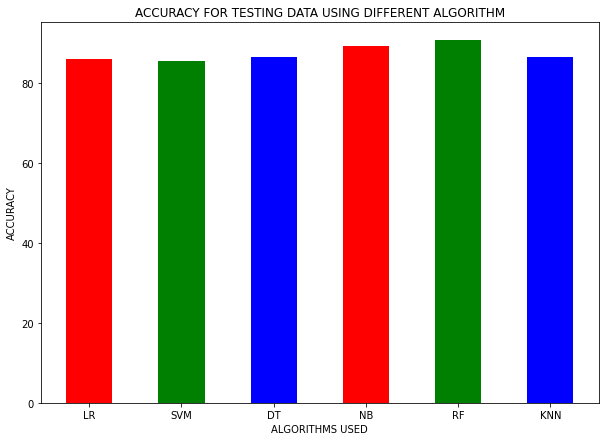

In [42]:
data_dict = {'LR':86.11, 'SVM':85.64, 'DT':86.57,'NB':89.35, 'RF':90.74, 'KNN':86.57}
courses = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (10, 7))
#  Bar plot
plt.bar(courses, values, color ='rgb',width = 0.5)
plt.xlabel("ALGORITHMS USED")
plt.ylabel("ACCURACY")
plt.title("ACCURACY FOR TESTING DATA USING DIFFERENT ALGORITHM")
plt.show()